In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!pwd

Fri Sep  5 13:20:29 PDT 2025
abie
/mnt/share/homes/abie/notebook/2025


## V&V List from Docs 
- Verify that all simulants in the model have AD (i.e., all recorded person-time is in the “AD” state, not the “susceptible” state)
- Verify that there are no transitions between AD states during the simulation (since it’s an SI model and all simulants should be in the I state the whole time)
- Verify total sim mortality against artifact (ACMR - CSMR + EMR)
- Validate Alzheimer’s EMR against GBD
- Verify the number of new simulants per year against the AD population model
- Use interactive sim to verify initial population structure against the AD population model
- For comparison with model 1, calculate total “real world” Alzheimer’s population over time (I’m not sure how closely we expect this to match model 1)

# Load Data

In [2]:
locations = ['united_states_of_america',
             'china'
            ]

results_dir_prefix = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

results_dirs = [
    results_dir_prefix + 'results/model3.1/united_states_of_america/2025_09_05_07_25_26/results/',
    results_dir_prefix + 'results/model3.1/china/2025_09_05_08_00_14/results/'
]

artifact_dirs = [results_dir_prefix + 'artifacts/model3.1/' + x + '.hdf' for x in locations]
artifact_dirs

['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model3.1/united_states_of_america.hdf',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model3.1/china.hdf']

In [3]:
[x for x in os.listdir(results_dirs[0]) if 'parquet' in x]

['deaths.parquet',
 'ylls.parquet',
 'new_simulants.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'ylds.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet']

In [4]:
age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
art = Artifact(artifact_dirs[0],
               filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
              )

age_dictionary = pd.DataFrame()
age_dictionary['age_group_id'] = age_group_ids
age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
artifact = art.load('population.structure').reset_index()
artifact = artifact.loc[artifact.age_start > 29].reset_index()
age_dictionary['age_start'] = artifact.age_start
age_dictionary['age_end'] = artifact.age_end
# age_dictionary.head()

## Verify that all simulants in the model have AD 

In [5]:
def load_df(measure):
    data = pd.DataFrame()
    for results_dir in results_dirs:
        temp = pd.read_parquet(results_dir + measure + '.parquet')
        
        # aggregate by summing value column over random seeds
        cols = [c for c in temp.columns if c not in ['value', 'random_seed']]
        temp = temp.groupby(cols)['value'].sum().reset_index()
        
        temp['location'] = locations[results_dirs.index(results_dir)].title()
        temp['current_year'] = temp['current_year'].astype(int)
        data = pd.concat([data, temp], ignore_index=True)
    return data

In [6]:
person_time = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

In [7]:
assert person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero years of person-time susceptible'

## Verify that there are no transitions between AD states during the simulation 

In [8]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

In [9]:
assert trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero transitions from susceptible to with-condition'

## Verify Total Sim Mortality against artifact (ACMR - CSMR + EMR)

In [10]:
%%time

cols = ['input_draw','current_year','location','age_group','sex']

def calculate_acmr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum(numeric_only=True)

    deaths = load_df('deaths')
    deaths = deaths.groupby(cols).sum(numeric_only=True)

    acmr = (deaths / total_pt)[['value']].reset_index()

    acmr = acmr.merge(age_dictionary, on=['age_group'])
    acmr = acmr.loc[acmr['age_group_id'].isin(age_group_ids)]
    acmr = acmr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return acmr

sim_acmr = calculate_acmr()

CPU times: user 29 s, sys: 292 ms, total: 29.3 s
Wall time: 29.3 s


In [11]:
art = Artifact(artifact_dirs[0])

a = art.load(f'cause.all_causes.cause_specific_mortality_rate')
b = art.load(f'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate')
c = art.load(f'cause.alzheimers_disease_and_other_dementias.excess_mortality_rate')

In [12]:
(a - b.droplevel(['year_start', 'year_end']) + c.droplevel(['year_start', 'year_end'])).dropna()

draw_0    draw_1    draw_2  \
sex    age_start age_end year_start year_end                                 
Female 5.0       10.0    2022       2023      0.000091  0.000093  0.000096   
                         2023       2024      0.000090  0.000092  0.000092   
                         2024       2025      0.000087  0.000089  0.000091   
                         2025       2026      0.000086  0.000087  0.000091   
                         2026       2027      0.000085  0.000086  0.000090   
...                                                ...       ...       ...   
Male   95.0      125.0   2046       2047      0.372704  0.354924  0.421332   
                         2047       2048      0.373342  0.354431  0.423507   
                         2048       2049      0.372457  0.353727  0.422012   
                         2049       2050      0.371923  0.353583  0.422097   
                         2050       2051      0.372239  0.356536  0.422698   

                                                draw_3    draw_4    draw_5  \
sex    age_start age_end year_start year_end                                 
Female 5.0       10.0    2022       2023      0.000093  0.000097  0.000093   
                         2023       2024      0.000091  0.000093  0.000091   
                         2024       2025      0.000091  0.000093  0.000089   
                         2025       2026      0.000088  0.000092  0.000089   
                         2026       2027      0.000087  0.000092  0.000087   
...                                                ...       ...       ...   
Male   95.0      125.0   2046       2047      0.506317  0.447196  0.344289   
                         2047       2048      0.504613  0.447884  0.343717   
                         2048       2049      0.503627  0.449094  0.343821   
                         2049       2050      0.503586  0.450830  0.341873   
                         2050       2051      0.503385  0.451930  0.340144   

                                                draw_6    draw_7    draw_8  \
sex    age_start age_end year_start year_end                                 
Female 5.0       10.0    2022       2023      0.000090  0.000095  0.000093   
                         2023       2024      0.000089  0.000092  0.000090   
                         2024       2025      0.000087  0.000089  0.000088   
                         2025       2026      0.000087  0.000087  0.000087   
                         2026       2027      0.000086  0.000083  0.000085   
...                                                ...       ...       ...   
Male   95.0      125.0   2046       2047      0.390629  0.416862  0.381331   
                         2047       2048      0.389223  0.416983  0.380716   
                         2048       2049      0.387863  0.417764  0.381475   
                         2049       2050      0.388245  0.417137  0.381577   
                         2050       2051      0.387123  0.418543  0.382274   

                                                draw_9  ...  draw_490  \
sex    age_start age_end year_start year_end            ...             
Female 5.0       10.0    2022       2023      0.000102  ...  0.000096   
                         2023       2024      0.000093  ...  0.000096   
                         2024       2025      0.000093  ...  0.000095   
                         2025       2026      0.000096  ...  0.000094   
                         2026       2027      0.000088  ...  0.000095   
...                                                ...  ...       ...   
Male   95.0      125.0   2046       2047      0.639484  ...  0.571756   
                         2047       2048      0.639165  ...  0.572954   
                         2048       2049      0.638398  ...  0.572819   
                         2049       2050      0.639090  ...  0.573682   
                         2050       2051      0.638207  ...  0.573450   

                                              draw_49

In [13]:
(a - b.droplevel(['year_start', 'year_end']) + c.droplevel(['year_start', 'year_end'])).dropna()

draw_0    draw_1    draw_2  \
sex    age_start age_end year_start year_end                                 
Female 5.0       10.0    2022       2023      0.000091  0.000093  0.000096   
                         2023       2024      0.000090  0.000092  0.000092   
                         2024       2025      0.000087  0.000089  0.000091   
                         2025       2026      0.000086  0.000087  0.000091   
                         2026       2027      0.000085  0.000086  0.000090   
...                                                ...       ...       ...   
Male   95.0      125.0   2046       2047      0.372704  0.354924  0.421332   
                         2047       2048      0.373342  0.354431  0.423507   
                         2048       2049      0.372457  0.353727  0.422012   
                         2049       2050      0.371923  0.353583  0.422097   
                         2050       2051      0.372239  0.356536  0.422698   

                                                draw_3    draw_4    draw_5  \
sex    age_start age_end year_start year_end                                 
Female 5.0       10.0    2022       2023      0.000093  0.000097  0.000093   
                         2023       2024      0.000091  0.000093  0.000091   
                         2024       2025      0.000091  0.000093  0.000089   
                         2025       2026      0.000088  0.000092  0.000089   
                         2026       2027      0.000087  0.000092  0.000087   
...                                                ...       ...       ...   
Male   95.0      125.0   2046       2047      0.506317  0.447196  0.344289   
                         2047       2048      0.504613  0.447884  0.343717   
                         2048       2049      0.503627  0.449094  0.343821   
                         2049       2050      0.503586  0.450830  0.341873   
                         2050       2051      0.503385  0.451930  0.340144   

                                                draw_6    draw_7    draw_8  \
sex    age_start age_end year_start year_end                                 
Female 5.0       10.0    2022       2023      0.000090  0.000095  0.000093   
                         2023       2024      0.000089  0.000092  0.000090   
                         2024       2025      0.000087  0.000089  0.000088   
                         2025       2026      0.000087  0.000087  0.000087   
                         2026       2027      0.000086  0.000083  0.000085   
...                                                ...       ...       ...   
Male   95.0      125.0   2046       2047      0.390629  0.416862  0.381331   
                         2047       2048      0.389223  0.416983  0.380716   
                         2048       2049      0.387863  0.417764  0.381475   
                         2049       2050      0.388245  0.417137  0.381577   
                         2050       2051      0.387123  0.418543  0.382274   

                                                draw_9  ...  draw_490  \
sex    age_start age_end year_start year_end            ...             
Female 5.0       10.0    2022       2023      0.000102  ...  0.000096   
                         2023       2024      0.000093  ...  0.000096   
                         2024       2025      0.000093  ...  0.000095   
                         2025       2026      0.000096  ...  0.000094   
                         2026       2027      0.000088  ...  0.000095   
...                                                ...  ...       ...   
Male   95.0      125.0   2046       2047      0.639484  ...  0.571756   
                         2047       2048      0.639165  ...  0.572954   
                         2048       2049      0.638398  ...  0.572819   
                         2049       2050      0.639090  ...  0.573682   
                         2050       2051      0.638207  ...  0.573450   

                                              draw_49

In [14]:
art_acmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    
    # TODO: consider better ways to broadcast years from excess mx
    a = art.load(f'cause.all_causes.cause_specific_mortality_rate')
    b = art.load(f'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate')
    c = art.load(f'cause.alzheimers_disease_and_other_dementias.excess_mortality_rate')
    
    data1 = (a - b.droplevel(['year_start', 'year_end']) + c.droplevel(['year_start', 'year_end'])).dropna()
    data2 = (data1.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data3 = data2.merge(age_dictionary, on=['age_start','age_end'])
    data4 = data3.loc[data3['age_group_id'].isin(age_group_ids)]
    data4['measure'] = 'acmr'
    data4['location'] = locations[artifact_dirs.index(artifact_dir)].title()
    art_acmr = pd.concat([art_acmr, data4])
art_acmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age_group_id,age_group_name,age_group,measure,location
0,Female,30.0,35.0,2022,2023,0.000931,0.000911,0.000951,11,30 to 34,30_to_34,acmr,United_States_Of_America
1,Female,30.0,35.0,2023,2024,0.000898,0.000875,0.000925,11,30 to 34,30_to_34,acmr,United_States_Of_America
2,Female,30.0,35.0,2024,2025,0.000900,0.000871,0.000935,11,30 to 34,30_to_34,acmr,United_States_Of_America
3,Female,30.0,35.0,2025,2026,0.000901,0.000865,0.000942,11,30 to 34,30_to_34,acmr,United_States_Of_America
4,Female,30.0,35.0,2026,2027,0.000902,0.000856,0.000950,11,30 to 34,30_to_34,acmr,United_States_Of_America


In [15]:
art_data = art_acmr
location = 'China'
sex='Female'
year=2030
art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]


,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age_group_id,age_group_name,age_group,measure,location
8,Female,30.0,35.0,2030,2031,0.000354,0.000252,0.000477,11,30 to 34,30_to_34,acmr,China
66,Female,35.0,40.0,2030,2031,0.000539,0.000395,0.000719,12,35 to 39,35_to_39,acmr,China
124,Female,40.0,45.0,2030,2031,0.003102,0.000982,0.010536,13,40 to 44,40_to_44,acmr,China
182,Female,45.0,50.0,2030,2031,0.004221,0.001435,0.012574,14,45 to 49,45_to_49,acmr,China
240,Female,50.0,55.0,2030,2031,0.007376,0.002707,0.021162,15,50 to 54,50_to_54,acmr,China
298,Female,55.0,60.0,2030,2031,0.011549,0.004460,0.029511,16,55 to 59,55_to_59,acmr,China
356,Female,60.0,65.0,2030,2031,0.016558,0.007502,0.036287,17,60 to 64,60_to_64,acmr,China
414,Female,65.0,70.0,2030,2031,0.023029,0.011906,0.048608,18,65 to 69,65_to_69,acmr,China
472,Female,70.0,75.0,2030,2031,0.033457,0.020086,0.061923,19,70 to 74,70_to_74,acmr,China
530,Female,75.0,80.0,2030,2031,0.048907,0.033261,0.078251,20,75 to 79,75_to_79,acmr,China


In [16]:
def age_group_plot(measure, sim_data, art_data):
    for location in sim_data.location.unique():
        for year in [2030,2040,2050]:
            for sex in sim_data.sex.unique():
                plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.current_year == year) & (sim_data.sex == sex)]
                art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]

                plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
                plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

                plt.plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {sex}')
                plt.fill_between(art_plot.age_start, art_plot['2.5%'], art_plot['97.5%'], alpha=0.2)

                plt.title(f"{measure} in {location} in {year}")
                plt.tick_params(axis='x', labelrotation=90)
                plt.xlabel("Age Group")
                plt.ylabel(f"{measure}")
                plt.legend()
#                 plt.semilogy()
            plt.figure()

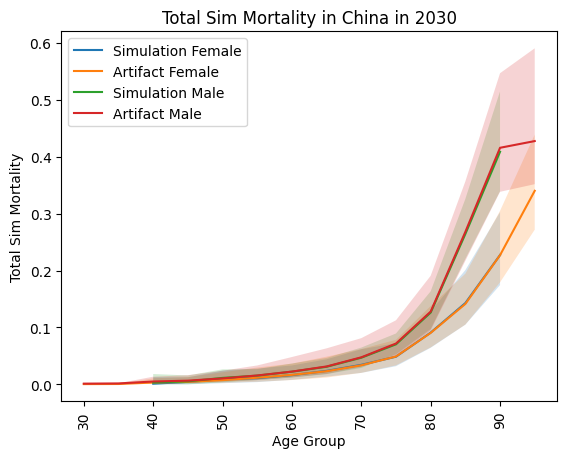

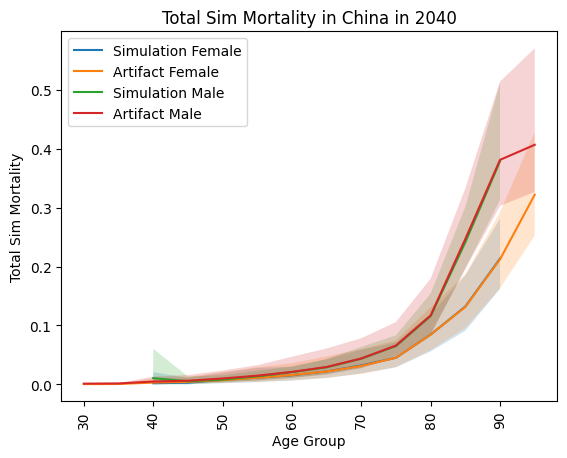

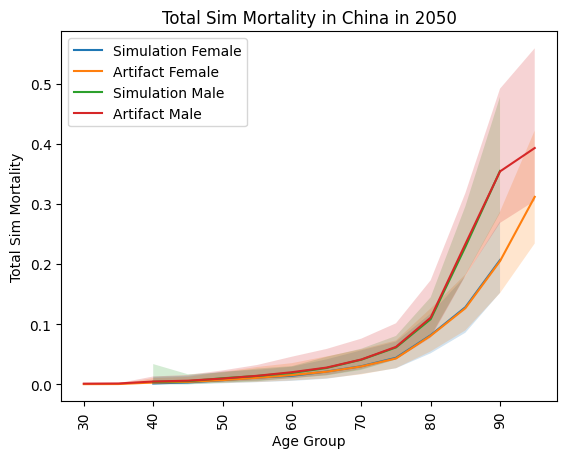

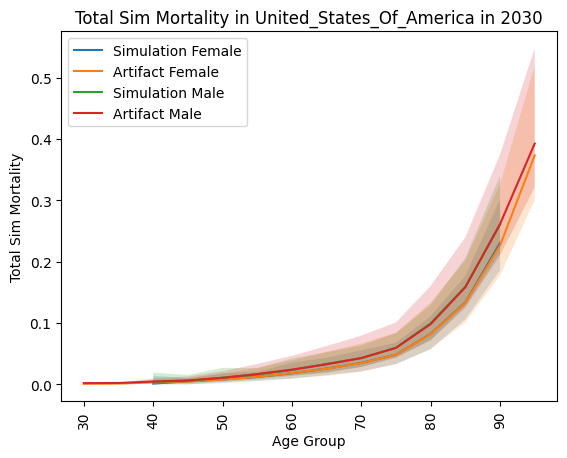

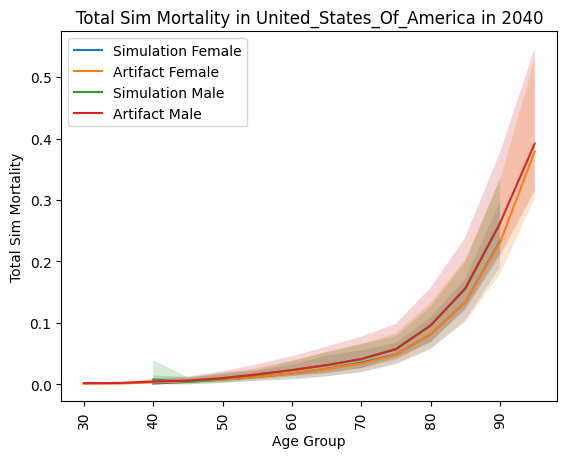

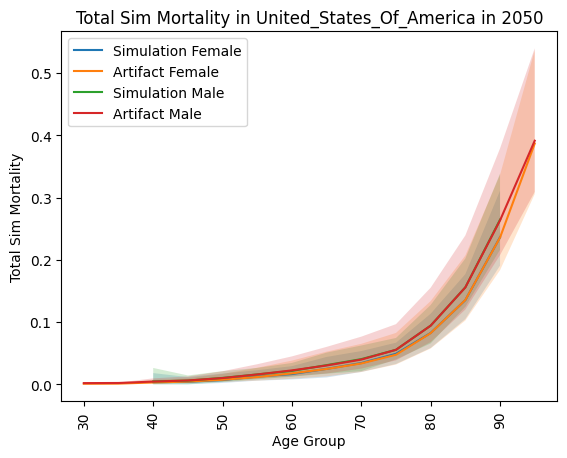

<Figure size 640x480 with 0 Axes>

In [17]:
age_group_plot('Total Sim Mortality', sim_acmr, art_acmr)

In [18]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.age_start == age_start) & (sim_data.sex == sex)]

            plt.plot(plot_data.current_year, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} Over Time Among Age Start Group {age_start}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

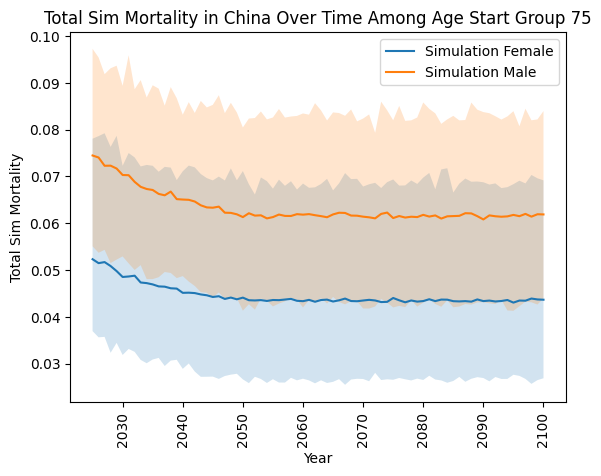

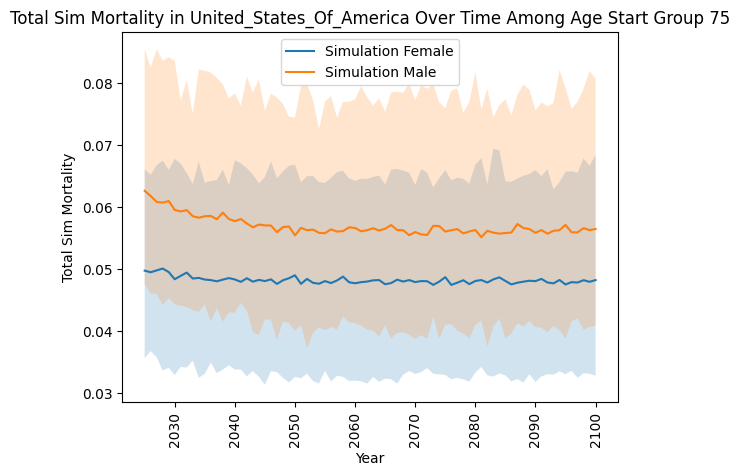

<Figure size 640x480 with 0 Axes>

In [19]:
over_time_plot('Total Sim Mortality', sim_acmr, 75)

## Validate Alzheimer’s EMR against GBD

In [20]:
cols = ['input_draw','current_year','location','age_group','sex']

def calculate_emr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time_total.loc[
        person_time_total.sub_entity == 'alzheimers_disease_and_other_dementias'
    ].groupby(cols).sum(numeric_only=True)

    deaths = load_df('deaths')
    deaths = deaths.loc[
        deaths.sub_entity == 'alzheimers_disease_and_other_dementias'
    ].groupby(cols).sum(numeric_only=True)

    acmr = (deaths / infected)[['value']].reset_index()

    acmr = acmr.merge(age_dictionary, on=['age_group'])
    acmr = acmr.loc[acmr['age_group_id'].isin(age_group_ids)]
    acmr = acmr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return acmr

sim_emr = calculate_emr()

In [21]:
def load_artifact_cause_data(measure):
    out = pd.DataFrame()
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
        data = art.load(f'cause.alzheimers_disease_and_other_dementias.{measure}')
        data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
                .filter(['mean', '2.5%', '97.5%']).reset_index())
        data = data.merge(age_dictionary, on=['age_start','age_end'])
        data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data['measure'] = measure
        data['location'] = locations[artifact_dirs.index(artifact_dir)].title()
        out = pd.concat([out, data])
    return out

In [22]:
art_emr = load_artifact_cause_data('excess_mortality_rate')
#art_emr.head()

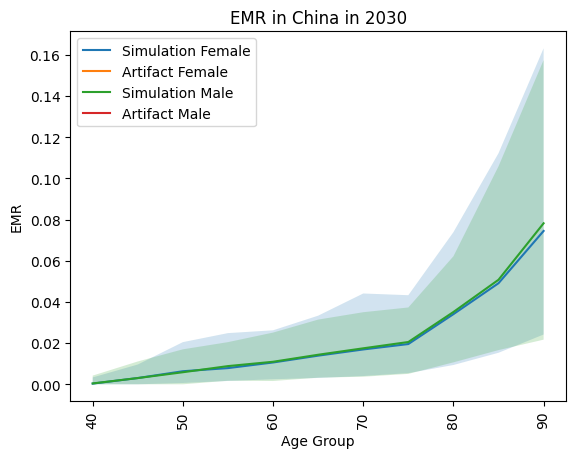

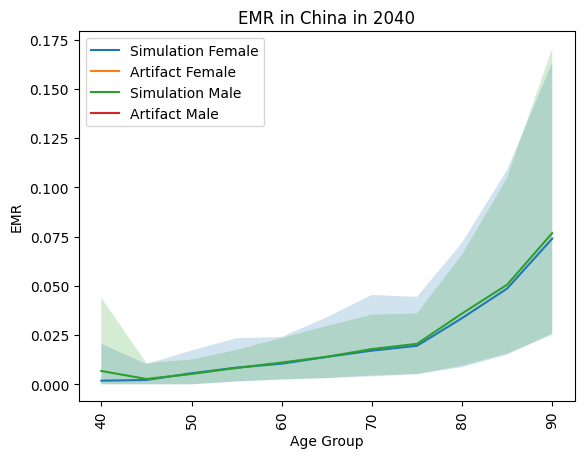

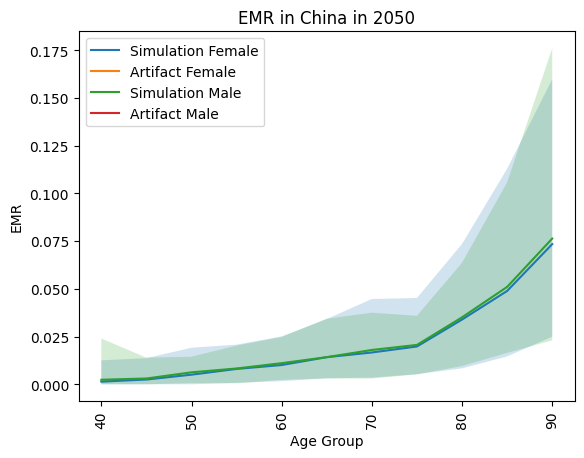

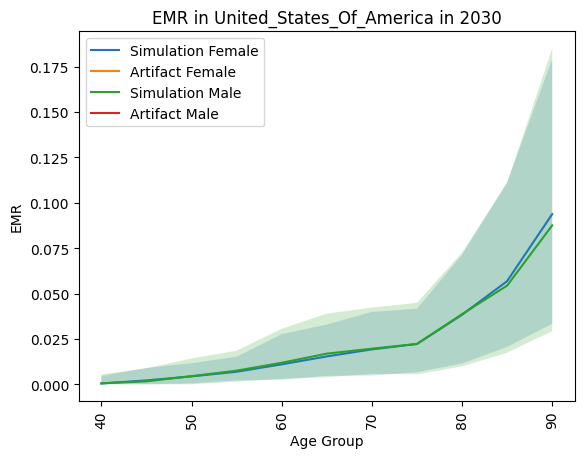

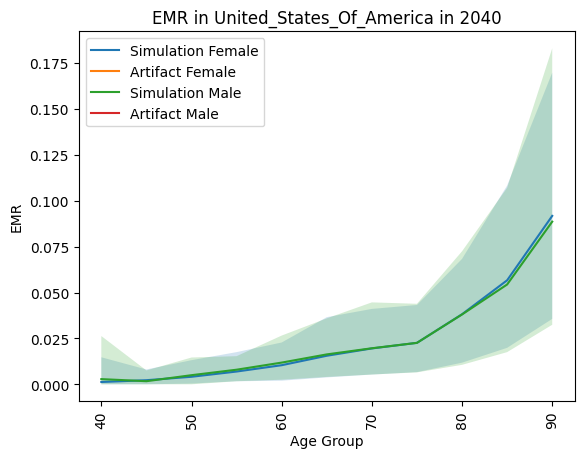

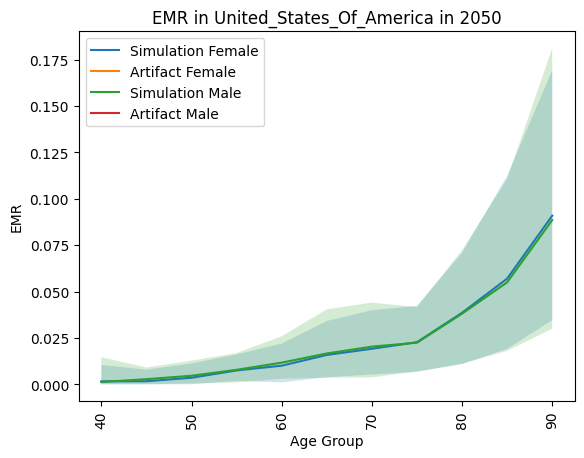

<Figure size 640x480 with 0 Axes>

In [23]:
age_group_plot('EMR', sim_emr, art_emr)

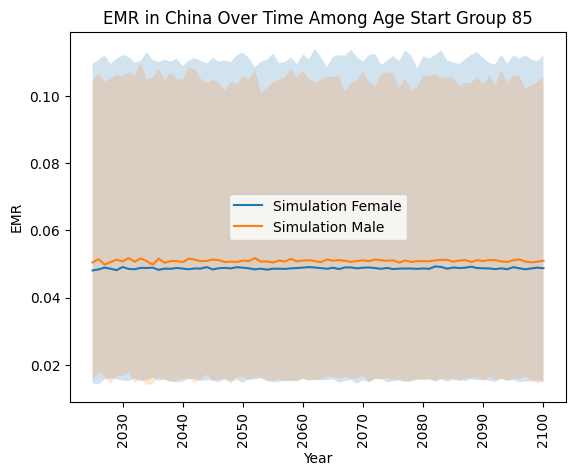

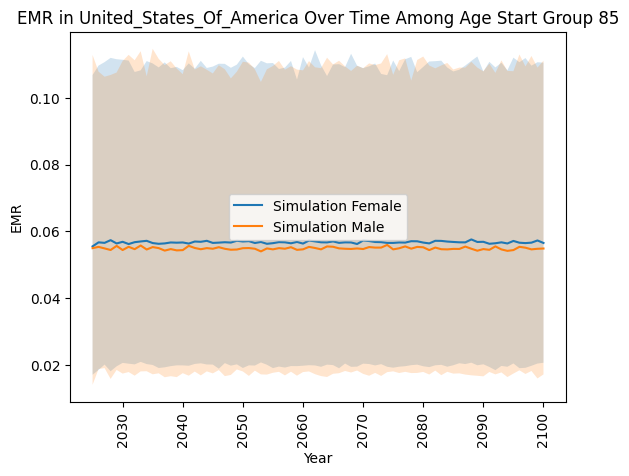

<Figure size 640x480 with 0 Axes>

In [24]:
over_time_plot('EMR', sim_emr, 85)

## Verify the number of new simulants per year against the AD population model

In [25]:
sex_ids = [1,2]
location_ids = [6,102]

gbd_data = get_outputs(topic='cause',
                      year_id=2021,
                      sex_id=sex_ids,
                      age_group_id=age_group_ids,
                      location_id=location_ids,
                      cause_id=543,
                      measure_id=[5,6],
                      metric_id=1,
                      release_id=9)
gbd_data['measure'] = gbd_data.measure_name.str.split(' ', expand=True)[0].str.lower()
gbd_data['location_name'] = gbd_data.location_name.str.replace(' ', '_').str.title()
gbd_data = gbd_data.merge(age_dictionary, on=['age_group_id','age_group_name'])
gbd_data.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,...,measure,measure_name,metric_name,sex,val,upper,lower,age_group,age_start,age_end
0,11,543,102,5,1,1,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,...,prevalence,Prevalence,Number,Male,0.0,0.0,0.0,30_to_34,30.0,35.0
1,11,543,102,5,1,2,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,...,prevalence,Prevalence,Number,Female,0.0,0.0,0.0,30_to_34,30.0,35.0
2,11,543,102,6,1,1,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,...,incidence,Incidence,Number,Male,0.0,0.0,0.0,30_to_34,30.0,35.0
3,11,543,102,6,1,2,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,...,incidence,Incidence,Number,Female,0.0,0.0,0.0,30_to_34,30.0,35.0
4,11,543,6,5,1,1,2021,neuro_dementia,30 to 34,Alzheimer's disease and other dementias,...,prevalence,Prevalence,Number,Male,0.0,0.0,0.0,30_to_34,30.0,35.0


In [26]:
art_incidence_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers_disease_and_other_dementias.population_incidence_rate'
        ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_incidence_data.append(df)
    
art_incidence_data = pd.concat(art_incidence_data)
for i in range(500):
    art_incidence_data[f'draw_{i}'] *= art_incidence_data[f'draw_{i}_pop']
    del art_incidence_data[f'draw_{i}_pop']
    

In [27]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load('population.structure').reset_index() 
    temp['location'] = temp.location.str.replace(' ', '_').str.title()
    
    df_prev_pop = pd.merge(
        art.load('cause.alzheimers_disease_and_other_dementias.prevalence_scale_factor').query("year_start == 2021"),
        art.load('population.structure').query("year_start==2025").droplevel(['year_start', 'year_end']),
        left_index=True,
        right_index=True,
        suffixes=['_prev', '_pop']
    )
    prev = ((df_prev_pop.filter(like='draw_').filter(like='_prev')
            * df_prev_pop.filter(like='draw_').filter(like='_pop').values).mean(axis=1)).sum(axis=0)
    # TODO: use draw-specific scale instead of mean

    ratio = 100_000 / prev
    temp['ratio'] = ratio

    temp = temp.rename(columns={'year_start': 'current_year'})
    temp = temp.merge(age_dictionary, on=['age_start','age_end'])
    temp = temp.loc[temp['age_group_id'].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
# scale

In [28]:
scale.groupby('location').ratio.describe()/5  # compare to 0.0035494897066482814 in interactive sim for USA

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
China,168.0,0.001013,1.735757e-19,0.001013,0.001013,0.001013,0.001013,0.001013
United_States_Of_America,168.0,0.003684,6.943028e-19,0.003684,0.003684,0.003684,0.003684,0.003684


In [29]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('new_simulants')
new_sims

,age_group,current_year,sex,scenario,input_draw,value,location
0,30_to_34,2025,Female,baseline,2,0.0,United_States_Of_America
1,30_to_34,2025,Female,baseline,13,0.0,United_States_Of_America
2,30_to_34,2025,Female,baseline,24,0.0,United_States_Of_America
3,30_to_34,2025,Female,baseline,41,0.0,United_States_Of_America
4,30_to_34,2025,Female,baseline,46,0.0,United_States_Of_America
...,...,...,...,...,...,...,...
106395,95_plus,2100,Male,baseline,446,64.0,China
106396,95_plus,2100,Male,baseline,457,195.0,China
106397,95_plus,2100,Male,baseline,460,136.0,China
106398,95_plus,2100,Male,baseline,480,113.0,China


In [30]:
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_sims

,age_group,current_year,sex,scenario,input_draw,value,location,ratio
0,30_to_34,2025,Female,baseline,2,0.0,United_States_Of_America,0.018420
1,30_to_34,2025,Female,baseline,13,0.0,United_States_Of_America,0.018420
2,30_to_34,2025,Female,baseline,24,0.0,United_States_Of_America,0.018420
3,30_to_34,2025,Female,baseline,41,0.0,United_States_Of_America,0.018420
4,30_to_34,2025,Female,baseline,46,0.0,United_States_Of_America,0.018420
...,...,...,...,...,...,...,...,...
33795,90_to_94,2050,Male,baseline,446,371.0,China,0.005065
33796,90_to_94,2050,Male,baseline,457,492.0,China,0.005065
33797,90_to_94,2050,Male,baseline,460,647.0,China,0.005065
33798,90_to_94,2050,Male,baseline,480,494.0,China,0.005065


In [31]:
new_sims['total_incidence'] = new_sims['value'] / new_sims['ratio']
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = new_sims.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_incidence'].reset_index()
new_sims

,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,China,30_to_34,Female,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2025,China,30_to_34,Male,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2025,China,35_to_39,Female,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2025,China,35_to_39,Male,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2025,China,40_to_44,Female,25.0,6270.621908,2540.152166,2171.814893,2764.128045,5923.131525,11806.775507,15005.266530
...,...,...,...,...,...,...,...,...,...,...,...,...
1347,2050,United_States_Of_America,80_to_84,Male,25.0,121218.823383,20955.057954,67534.402336,87859.868763,119813.847232,159541.882304,174101.952004
1348,2050,United_States_Of_America,85_to_89,Female,25.0,183639.286250,27604.810523,120628.168803,131051.484920,188488.299768,223026.392024,228498.632985
1349,2050,United_States_Of_America,85_to_89,Male,25.0,126743.180925,20455.943976,81975.038206,92528.645773,128065.639157,159194.438433,166067.312498
1350,2050,United_States_Of_America,90_to_94,Female,25.0,119466.403361,20411.972449,83223.664615,88695.905576,117045.153888,165806.729595,184308.115701


In [32]:
new_sims = new_sims.merge(age_dictionary, on=['age_group'])
new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
# new_sims

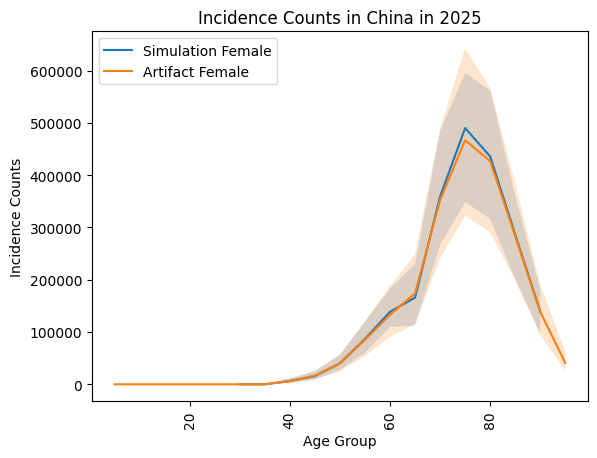

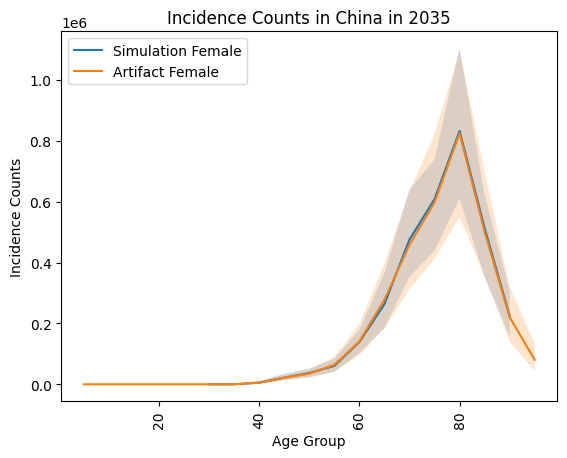

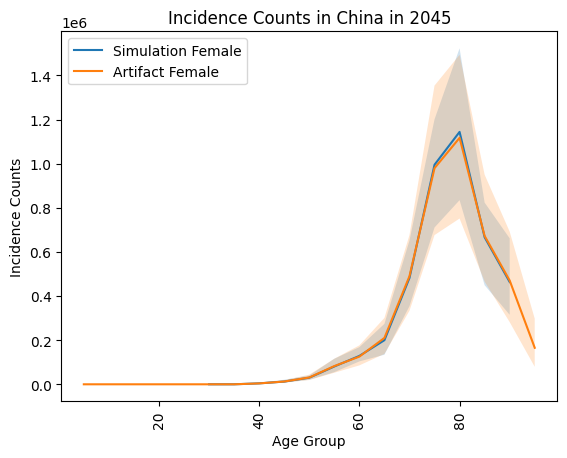

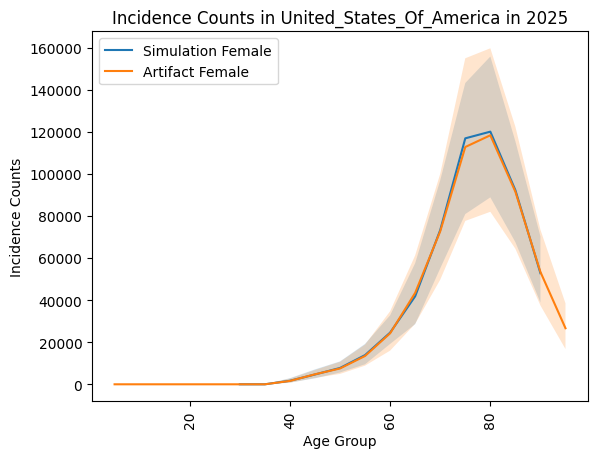

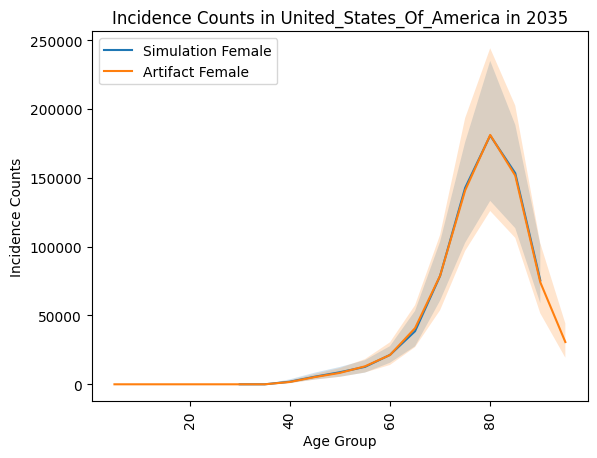

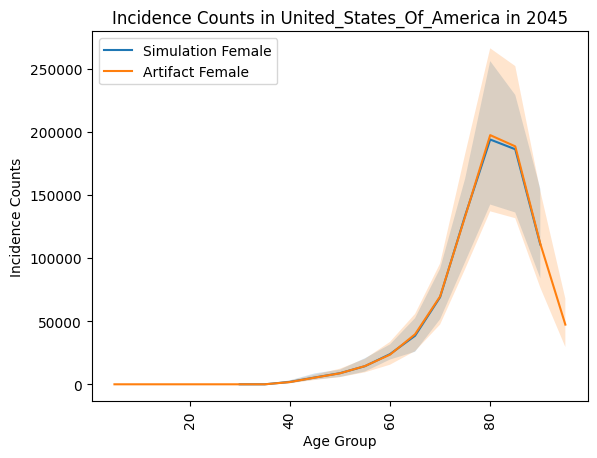

<Figure size 640x480 with 0 Axes>

In [33]:
for location in new_sims.location.unique():
    for year in [2025, 2035, 2045]:
        for sex in new_sims.sex.unique()[:1]:
            plot_data = new_sims.loc[(new_sims.location == location) & (new_sims.current_year == year) & (new_sims.sex == sex) ]
            gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'incidence')]
            location_w_spaces = location.replace('_', ' ').replace('Of', 'of')
            art_plot = art_incidence_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
#             import pdb; pdb.set_trace()
            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

#             plt.plot(gbd_plot.age_start, gbd_plot['val'], label=f'GBD {sex}')
#             plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"Incidence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Incidence Counts")
            plt.legend()
        plt.figure()

## Verifying Prevalence

In [34]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers_disease_and_other_dementias.prevalence_scale_factor'
                ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_prev_data.append(df)
    
art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f'draw_{i}'] *= art_prev_data[f'draw_{i}_pop']
    del art_prev_data[f'draw_{i}_pop']
art_prev_data

draw_0  \
sex    age_start age_end location                 year_start year_end                 
Female 5.0       10.0    United States of America 2021       2022          0.000000   
                                                  2022       2023          0.000000   
                                                  2023       2024          0.000000   
                                                  2024       2025          0.000000   
                                                  2025       2026          0.000000   
...                                                                             ...   
Male   95.0      125.0   China                    2046       2047      54694.496734   
                                                  2047       2048      59326.860991   
                                                  2048       2049      64904.930354   
                                                  2049       2050      70052.697307   
                                                  2050       2051      73804.796229   

                                                                              draw_1  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   China                    2046       2047      106663.545325   
                                                  2047       2048      116389.612316   
                                                  2048       2049      128097.284619   
                                                  2049       2050      139376.534789   
                                                  2050       2051      148438.840467   

                                                                              draw_2  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   China                    2046       2047      173954.592412   
                                                  2047       2048      191371.978145   
                                                  2048       2049      212536.216416   
                                                  2049       2050      233069.706203   
                                                  2050       2051      249521.210435   

                                                                              draw_3  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                    

In [35]:
new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_sims

,measure,entity_type,entity,sub_entity,age_group,current_year,sex,scenario,input_draw,value,location,ratio
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_and_other_dementias,30_to_34,2025,Female,baseline,2,0.0,United_States_Of_America,0.018420
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_and_other_dementias,30_to_34,2025,Female,baseline,13,0.0,United_States_Of_America,0.018420
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_and_other_dementias,30_to_34,2025,Female,baseline,24,0.0,United_States_Of_America,0.018420
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_and_other_dementias,30_to_34,2025,Female,baseline,41,0.0,United_States_Of_America,0.018420
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_and_other_dementias,30_to_34,2025,Female,baseline,46,0.0,United_States_Of_America,0.018420
...,...,...,...,...,...,...,...,...,...,...,...,...
67595,person_time,cause,alzheimers_disease_and_other_dementias,susceptible_to_alzheimers_disease_and_other_de...,90_to_94,2050,Male,baseline,446,0.0,China,0.005065
67596,person_time,cause,alzheimers_disease_and_other_dementias,susceptible_to_alzheimers_disease_and_other_de...,90_to_94,2050,Male,baseline,457,0.0,China,0.005065
67597,person_time,cause,alzheimers_disease_and_other_dementias,susceptible_to_alzheimers_disease_and_other_de...,90_to_94,2050,Male,baseline,460,0.0,China,0.005065
67598,person_time,cause,alzheimers_disease_and_other_dementias,susceptible_to_alzheimers_disease_and_other_de...,90_to_94,2050,Male,baseline,480,0.0,China,0.005065


In [36]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_sims['total_prev'] = new_sims['value'] / new_sims['ratio']
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = new_sims.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()

new_sims = new_sims.merge(age_dictionary, on=['age_group'])
new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
new_sims.head()

,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
0,2025,China,30_to_34,Female,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,30 to 34,30.0,35.0
1,2025,China,30_to_34,Male,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,30 to 34,30.0,35.0
2,2025,United_States_Of_America,30_to_34,Female,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,30 to 34,30.0,35.0
3,2025,United_States_Of_America,30_to_34,Male,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,30 to 34,30.0,35.0
4,2026,China,30_to_34,Female,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,30 to 34,30.0,35.0


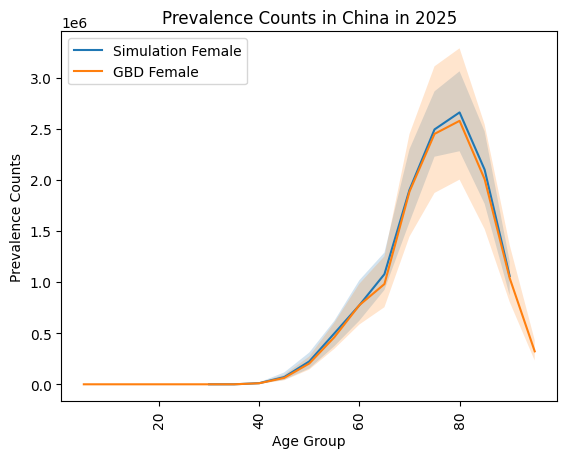

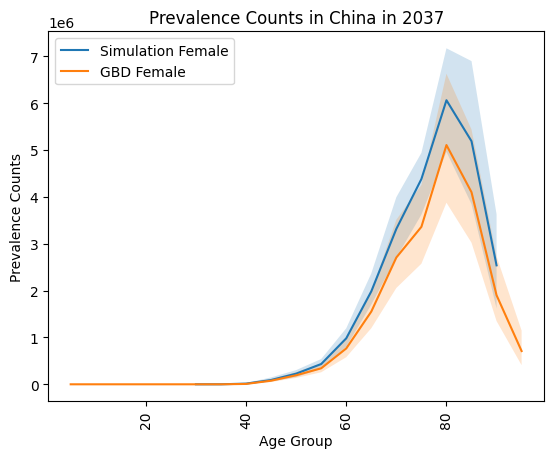

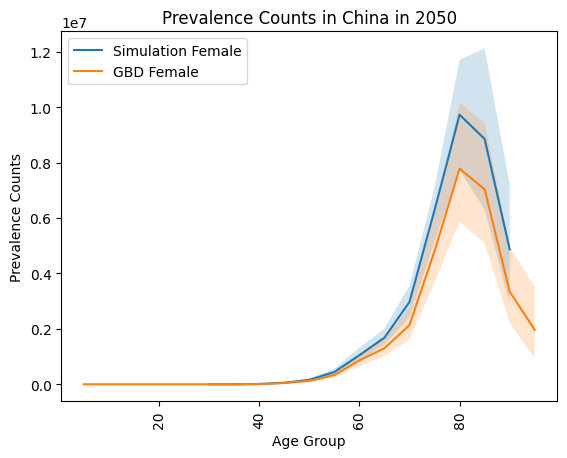

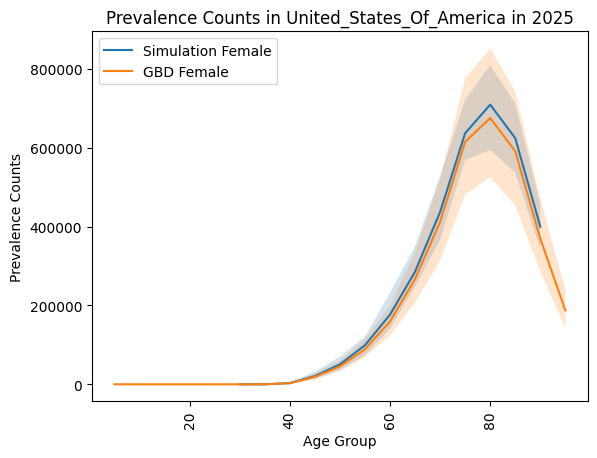

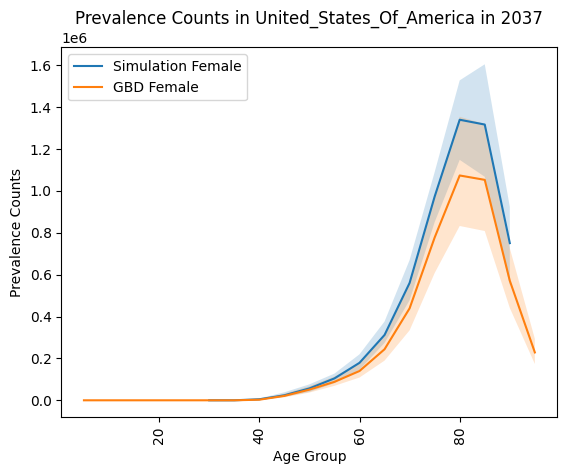

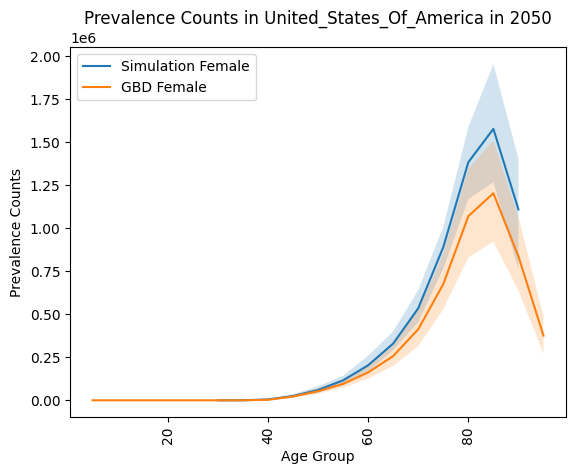

<Figure size 640x480 with 0 Axes>

In [37]:
for location in new_sims.location.unique():
    for year in [2025,2037,2050]:
        for sex in new_sims.sex.unique()[:1]:
            plot_data = new_sims.loc[(new_sims.location == location) & (new_sims.current_year == year) & (new_sims.sex == sex) ]
            gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace('_', ' ').replace('Of', 'of')
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'GBD {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"Prevalence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
        plt.figure()

## Total Sim Population Over Time (infected only) 

In [38]:
cols = ['input_draw','current_year','location'] #, 'age_group']

person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_total = person_time_total.groupby(cols)['value'].sum().reset_index()
person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
person_time_total#.head()

,current_year,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,China,25.0,102246.541602,393.588212,101371.728953,101428.545380,102369.774127,102807.571253,102820.197125
1,2025,United_States_Of_America,25.0,102153.210349,399.934451,101319.121150,101451.692813,102245.519507,102670.189733,102677.404517
2,2026,China,25.0,110508.692238,1875.333546,106407.047228,106471.379055,111054.570842,113046.652977,113081.223819
3,2026,United_States_Of_America,25.0,109791.863326,1930.062624,105903.014374,106370.472279,110437.806982,112162.741684,112385.798768
4,2027,China,25.0,118671.038357,3290.672003,111259.991786,111682.657906,119628.640657,123054.560986,123056.665298
...,...,...,...,...,...,...,...,...,...,...
147,2098,United_States_Of_America,25.0,202153.228419,22099.049722,163689.930185,165175.875154,205006.595483,229641.577002,229817.437372
148,2099,China,25.0,304977.634168,46023.834201,227661.519507,233831.663244,311997.338809,379759.696099,399932.533881
149,2099,United_States_Of_America,25.0,202132.285503,22056.793082,163570.184805,165142.707187,204935.449692,229428.841068,229800.402464
150,2100,China,25.0,304955.649117,45947.240260,227804.312115,233854.209446,312110.570842,379417.194251,399902.973306


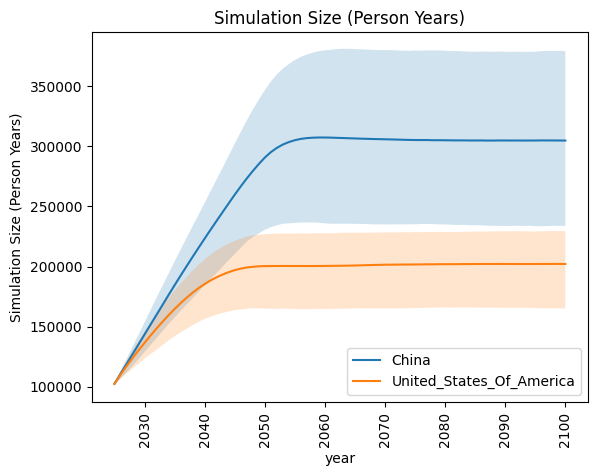

In [39]:
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[(person_time_total.location == location)]
    plt.plot(plot_data.current_year, plot_data['mean'], label=location)
    plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
    plt.title(f"Simulation Size (Person Years)")
    plt.tick_params(axis='x', labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()